# DSFB Course Project: Predicting IPO Share Price

![](https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg)

image source : https://img.etimg.com/thumb/height-480,width-640,msid-64038320,imgsize-108012/stock-market2-getty-images.jpg

## Introduction

An Initial Public Offering (IPO) is the process by which a private company becomes publicly traded on a stock exchange. The IPO company offers its shares to public investors in exchange of capital for sustaining expansion and growth. For this reason, IPOs are often issued by small or young companies, but they can also be done by large  companies looking to become publicly traded. During an IPO, the company obtains the assistance of an investment bank (underwriter), which helps determine the type, amount and price of the shares being offered. Decisions about the offering price are particularly important to avoid incurring excessive costs and maximize the capital received in the IPO. However at the end of the first trading day, price of each share can change due to market dynamics, which can lead to a price higher or lower than the offering one.

During an Initial Public Offering (IPO), the firm’s management have to disclose all relevant information about their business in a filing with the government called the "IPO Prospectus." Although there might be concerns about the public disclosure of sensitive information in the Prospectus that can help competitors, firms are encouraged to be as transparent as possible in order to avoid future litigation (lawsuits). A key textual field from the prospectus is:

__Risk_Factors__: Firms have to disclose all relevant information about internal or external risk factors that might affect future business performances. This information is contained in the “Risk Factors” section of the IPO prospectus. 

The key pricing variables are:

__Offering_Price__: the price at which a company sells its shares to investors.

__Num_Shares__: the total number of outstanding shares.

__Closing_Price__: (at the end of the first day of training) price at which shares trade in the open market, measured at the end of the first day of trading.

In this project you are provided with IPO data of different firms that are collected from different sources. You can find the dataset under project directory in the course git repository under the name of *ipo.xlsx*. The description of other variables can be found in *variable_description.xlsx*.

This Notebook will be presented as follow :

# Pre Processing
#####  libraries & useful functions
## 1 Import Dataset
## 2 Pre-processing of Dates Features
## 3 Pre-processsing of Special Features
## 4 Pre-processing of Categorical Features
## 5 Pre-processing of Ordinal Features
## 6 Pre-processing of Numerical Features
# -----------------------------------------
## 7 Pre-processing of Textual Features
## 8 Target
## 9 Feature Reduction
        1 Correlation with target
        2 Correlation between features

# Pre-Processing

##### Libraries & Useful functions  

In [219]:
import seaborn as sns
import re as re
import nltk
import datetime as dt
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from sklearn.base import TransformerMixin
from sklearn.metrics import roc_curve
from nltk.corpus import stopwords 

In [220]:
from preprocessing_functions import *

## 1 Import Dataset 

##### Import,  explore dataset and check missing values

In [221]:
#read dataset
DATA_FOLDER = 'data'
ipo = pd.read_excel(DATA_FOLDER + '/ipo.xlsx')
ipo_to_predict = pd.read_excel(DATA_FOLDER+'/ipo_to_predict.xlsx')

#merge
ipo = ipo.append(ipo_to_predict, ignore_index=True)

/home/guillaume_grandjean77/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


#### Declaration of categorization table to use in the data preprocessing

##### Date Columns

In [222]:
date_col = ['amd_date', 'lockup_date', 'lockup_days']

##### Ordinal Columns

In [223]:
ord_col = []

##### Numerical Columns

In [224]:
num_col = ['amd_nbr','round_tot','mgt_fee', 'gross_spread', 'min_round_vexp','avg_round_vexp', 'max_round_vexp',\
           'min_firm_amt_vexp', 'avg_firm_amt_vexp', 'max_firm_amt_vexp',\
          'min_fund_amt_vexp', 'max_fund_amt_vexp']

##### Categorical Columns

In [225]:
cat_col = ['exch', 'mgrs_role', 'mgrs','all_sic' ,'description','ht_ind', 'ht_ind_gr', 'ind_group','legal', 'uop' ]

##### Columns to Drop

In [226]:
columns_to_drop = ['ID','dj_avg_2','nasdaq_avg_2','SP2','SP4']

#### Explore data set

In [227]:
#Check if duplicates
ipo[ipo.astype(str).duplicated()==True]

,Closing_Price,ID,Num_Shares,Offering_Price,Price_All,Price_Change_All,Price_Change_Non_Textual,Price_Change_Textual,Risk_Factors,SEC_fee,...,tot_ass_after,tot_inv,tot_mgtfee,tot_proceeds,tot_shs_offered,underw_fee,uop,vc,veic_descr,zip


In [228]:
#Number of actual features
len(ipo.columns)

159

In [229]:
# check missing values
nb_missing_values = sum(map(any, ipo.isnull()))
nb_missing_values

159

In [230]:
#Count missing 
features_with_nan = len(ipo) - ipo.count()
features_with_nan=features_with_nan[features_with_nan!=0]
nan_percentage=(features_with_nan/len(ipo)).to_frame('percentage').reset_index().rename(columns={'index':'feature'})

In [231]:
features_nan_percentage = nan_percentage[nan_percentage.percentage>0.5]
features_nan_percentage

,feature,percentage
1,Price_All,1.000000
2,Price_Change_All,1.000000
3,Price_Change_Non_Textual,1.000000
4,Price_Change_Textual,1.000000
6,Your_Bet,1.000000
22,bvps_bef_offer,0.592113
39,int_aft,0.594416
40,int_bef,0.591249
41,intern)shs,0.800518
66,pb_value,0.593552


In [232]:
#Drop column with more than 50% of missing values
list_to_append = features_nan_percentage.feature.values
columns_to_drop = add_list_to_list(list_to_append, columns_to_drop)

In [233]:
#Check type of values
ipo.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64'), dtype('<M8[ns]')],
      dtype=object)

In [234]:
#Devide dataframe in function of type.
ints = ipo.select_dtypes(include='int64')
floats = ipo.select_dtypes(include='float64')
objects = ipo.select_dtypes(include='object')
timestamps = ipo.select_dtypes(include='M8[ns]')

In [235]:
# make a copy of the df
ipo_processing = ipo.copy()

## 2 Pre-processsing of Date Features


### amd_date
@Guillaume

In [236]:
#calculate number of amendment
ipo_processing['amd_nbr'] = ipo['amd_date'].apply(lambda x:  str(x).count('\n')+1 if( str(x).count('\n') > 0) else ( 1 if(len(str(x)) > 0) else 0 ) )
num_col.append('amd_nbr')
columns_to_drop.append('amd_date')

### lockup_date

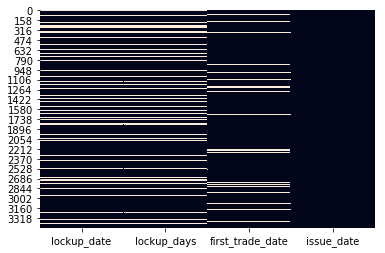

In [274]:
#Check if missing values are the same
sns.heatmap(ipo[['lockup_date','lockup_days', ]].isnull(), cbar=False)

In [238]:
#Get days only last 
ipo_processing['lockup_last_duration'] = ipo['lockup_days'].apply(lambda x: str(x) if( pd.isnull(x) ) else str(x)[-3:] )
#Cast it as a number
ipo_processing['lockup_last_duration'] = ipo_processing['lockup_last_duration'].apply(lambda x: int(x) if( str(x).isdigit() ) else np.nan )
#replace missing values
ipo_processing['lockup_last_duration'] = replace_nan(ipo_processing['lockup_last_duration'], '')

#Add
num_col.append('lockup_last_duration')

#We remove lockup_date because this information is rundandant in the lockup days we can calculate from the frist trade date
columns_to_drop.append('lockup_date')

#nan :646


### offer_date, first_trade_date, issue_date

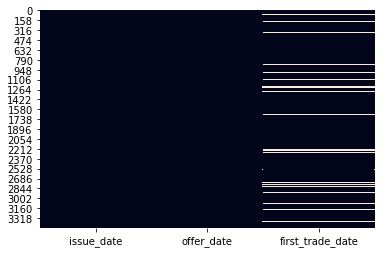

In [285]:
#Compare number of missing value offer_date and issue_date ares nearly the same.
sns.heatmap(ipo[['issue_date','offer_date', 'first_trade_date']].isnull(), cbar=False)

In [295]:
#Replace missing value by the most frequent one and get timestamp to compare datas
for columnWeTransform in ['issue_date','offer_date', 'first_trade_date']:
    ipo_processing[columnWeTransform] = ipo[columnWeTransform].apply(lambda x: str(x)[0:10])
    ipo_processing[columnWeTransform] = replace_nan(ipo[columnWeTransform], '1900-01-01')
    ipo_processing[columnWeTransform] = ipo_processing[columnWeTransform].apply(lambda x: pd.to_datetime(x).timestamp())

#nan :0
#nan :0
#nan :334


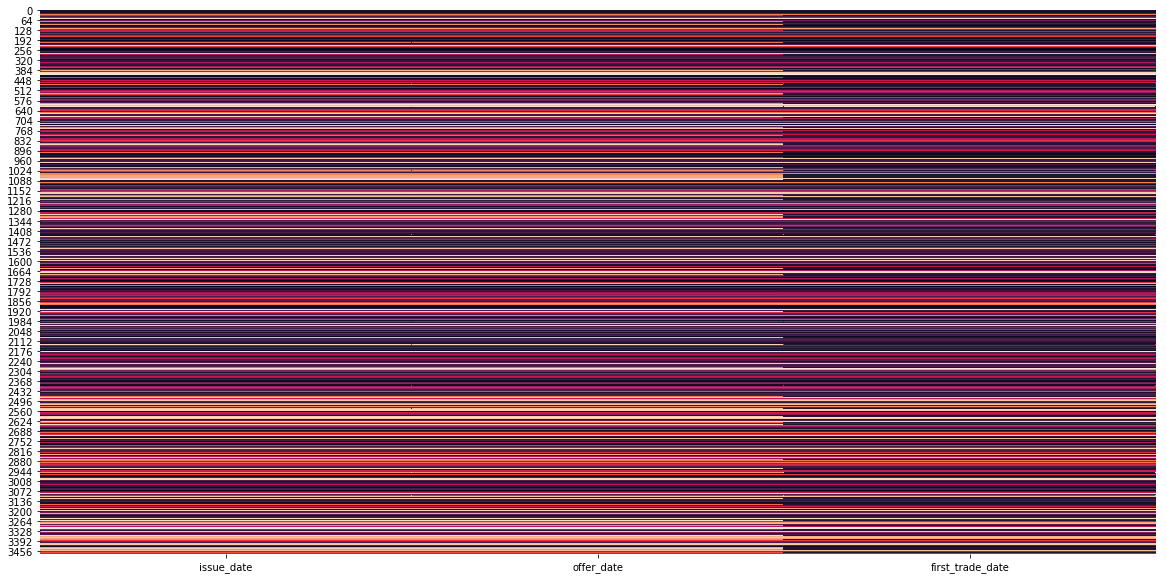

In [303]:
#Look at the values
plt.figure(figsize=(20,10))
sns.heatmap(ipo_processing[['issue_date','offer_date', 'first_trade_date']], cbar=False)

In [304]:
#drop first_trade_date and issue_date and keep offer_date
columns_to_drop.append('first_trade_date')
columns_to_drop.append('issue_date')
columnWeTransform = 'offer_date'

# read dataset of the american 10 year bond rate
# This give us more info on the actual risk premium
rate = pd.read_csv(DATA_FOLDER + '/HQMCB10YR.csv')
rate.rename(columns = {'DATE':columnWeTransform, 'HQMCB10YR':'rate'}, inplace = True)
rate[columnWeTransform] = rate[columnWeTransform].apply(lambda x: pd.to_datetime(x))
rate.head(2)

#Merge rate on the dataframe
ipo_processing[columnWeTransform] = ipo[columnWeTransform].apply(lambda x: pd.to_datetime(str(x.year)+'-'+str(x.month)+'-01') if( not(pd.isna(x))) else pd.to_datetime('1900-01-01'))
ipo_processing = ipo_processing.merge(rate, how='left')
columns_to_drop.append(columnWeTransform)
num_col.append('rate')

#Replace missing value rate
ipo_processing.rate = replace_nan(ipo_processing.rate, '')

#Replace missing value by the most frequent one.
ipo_processing[columnWeTransform] = ipo[columnWeTransform].apply(lambda x: str(x)[0:10])
ipo_processing[columnWeTransform] = replace_nan(ipo[columnWeTransform], '1900-01-01')
ipo_processing[columnWeTransform] = ipo_processing[columnWeTransform].apply(lambda x: pd.to_datetime(x))

#get datetime object for each row
ipo_processing[columnWeTransform+'_day'] = ipo_processing[columnWeTransform].apply(lambda x: int(x.day) )
cat_col.append(columnWeTransform+'_day')

ipo_processing[columnWeTransform+'_weekday'] = ipo_processing[columnWeTransform].apply(lambda x: int(x.weekday()) )
cat_col.append(columnWeTransform+'_weekday')

ipo_processing[columnWeTransform+'_month'] = ipo_processing[columnWeTransform].apply(lambda x: int(x.month) )
cat_col.append(columnWeTransform+'_month')

ipo_processing[columnWeTransform+'_year'] = ipo_processing[columnWeTransform].apply(lambda x: int(x.year) )
cat_col.append(columnWeTransform+'_year')

ipo_processing[columnWeTransform+'_timestamp'] = ipo_processing[columnWeTransform].apply(lambda x: dt.datetime(year=int(x.year), month=int(x.month), day=int(x.day)).timestamp())
num_col.append(columnWeTransform+'_timestamp')

#nan :0
#nan :0


### date_amd

In [305]:
#Convert from excel date to datetime
ipo_processing['date_amd'] = replace_nan(ipo['date_amd'], '')
ipo_processing['date_amd'] = ipo_processing['date_amd'].apply(lambda x: from_excel_ordinal(x) )

#Calculate difference between date_amd and offer_date save number of days as int
ipo_processing['offer_date'] = ipo['offer_date'].apply(lambda x: pd.to_datetime(x) )
ipo_processing['time_amd'] = ipo_processing.apply(lambda x: x['offer_date']-x['date_amd'], axis=1 )
ipo_processing['time_amd'] = ipo_processing['time_amd'].apply(lambda x: x.days)
num_col.append('time_amd')

#column to drop:
columns_to_drop.append('date_amd')

#nan :11


## 3 Pre-processsing of Special Features


### description

We split it into 2 one numerical and second categorical

In [241]:
ipo['description'].head(2)

0    5,000,000.0 Common Shares
1    6,898,541.0 Common Shares
Name: description, dtype: object

In [242]:
# delete the ',' in the features description
ipo_processing['description'] = ipo['description'].str.replace(',','',regex=False)

# split description into 2 string
split_description = ipo_processing.description.str.split('.0 ')

# create desctiption_numeric as the nb written in description 
ipo_processing['description_numeric']= split_description.apply(lambda x: int(x[0]))
num_col.append('description_numeric')

# create description cat as the category of the number of shares
ipo_processing['description_cat'] =  split_description.apply(lambda x: x[1])
cat_col.append('description_cat')

# drop description
columns_to_drop.append('description')

### all_sic

We will reduce this number by a 2 digit categories for all_sic

In [243]:
ipo_processing.all_sic = ipo.all_sic.str.split('/')

ipo_processing.all_sic = ipo_processing.all_sic.apply(lambda x: [a[:2] for a in x])

We will use this file to reduce the number of categories:

In [244]:
all_sic_mapping = pd.read_excel(DATA_FOLDER + '/all_sic_mapping.xlsx',delimiter = ',')

In [245]:
## Cleaning file:
all_sic_mapping.range_sic = all_sic_mapping.range_sic.str.split('-')
all_sic_mapping.range_sic= all_sic_mapping.range_sic.apply(lambda x: [int(a[:2]) for a in x])
all_sic_mapping.range_sic = all_sic_mapping.range_sic.apply(lambda x: np.arange(x[0],x[1]+1))

In [246]:
## Map all_sic values to new ones
splitted = all_sic_mapping.range_sic.apply(pd.Series).stack().reset_index(level = 1,drop = True).to_frame('range')
merged = pd.merge(splitted,all_sic_mapping,left_on = splitted.index, right_on=  all_sic_mapping.index,how = 'left')
merged_2 = merged[['range','cat']]
merged_2.range = merged_2.range.astype(int)
merged_2.set_index('range',inplace = True)

#Apply to the dataset
ipo_processing.all_sic = ipo_processing.all_sic.apply(lambda x : [merged_2.loc[int(a)] if (int(a) in merged_2.index.values) else int(a) for a in x ] )
ipo_processing.all_sic = ipo_processing.all_sic.apply(lambda x: [item for sublist in x for item in sublist])

/home/guillaume_grandjean77/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [247]:
ipo_processing = pd.concat([ipo_processing,pd.get_dummies(ipo_processing.all_sic.apply(pd.Series).stack()).sum(level=0)],axis = 1)

#Add new categorical col
cat_col = add_list_to_list(all_sic_mapping.cat, cat_col)

#Columns to drop
columns_to_drop.append('all_sic')


### zip
We will use this file 'us_postal_codes.csv' to get cities and state to replace where there is missing values

In [248]:
#Read us postal file
us_zip = pd.read_csv(DATA_FOLDER + '/us_postal_codes.csv', sep=',')
us_zip.rename(columns={'Zip Code': 'zip', 'Place Name':'city_zip', 'State':'state_zip'}, inplace=True)

# Drop infos that we don't want
us_zip = us_zip.drop(columns=['State Abbreviation', 'County', 'Latitude', 'Longitude'])
us_zip.head()

#Merge in function of the ZIP code
ipo_processing.zip = ipo.zip.apply(lambda x: str(x)[:5])
ipo_processing.zip = ipo_processing.zip.apply(lambda x: int(x) if (str.isdigit(x)) else 0 )
ipo_processing['zip'] = ipo_processing.apply(lambda x: int(str(x['zip'])[:5]) if ( str(x['nation']) == 'United States' ) else 0 , axis=1)
ipo_processing = ipo_processing.merge(us_zip, how='left')
ipo_processing.state.fillna('Outside US', inplace=True)

#Replace where missing city and stateS
print("Number of city replaced : " + str(ipo_processing['city'].isna().sum() - ipo_processing['city_zip'].loc[ipo_processing['city'].isna()].isna().sum()))
ipo_processing['city'].loc[ipo_processing['city'].isna()] = ipo_processing.loc[ipo_processing['city'].isna()]['city_zip']

print("Number of state replaced : " + str(ipo_processing['state'].isna().sum() - ipo_processing['state_zip'].loc[ipo_processing['state'].isna()].isna().sum()))
ipo_processing['state'].loc[ipo_processing['state'].isna()] = ipo_processing.loc[ipo_processing['state'].isna()]['state_zip']

#Remove city_zip and zip
columns_to_drop.append('state_zip')
columns_to_drop.append('city_zip')
columns_to_drop.append('zip')

Number of city replaced : 1
Number of state replaced : 0


/home/guillaume_grandjean77/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## 4 Pre-processing of Categorical Features


### issuer

Issuer is not relevant because has same number of issuer than number of row

In [249]:
len(ipo['issuer']) == len(ipo.issuer.unique())

True

In [250]:
columns_to_drop.append('issuer')

### Processing categories with \n separator

In [251]:
columns_with_n = ['mgrs_role','mgrs','ht_ind_gr','ht_ind','uop','legal','exch','br']

for col in columns_with_n:
    print('processing column ' + col)
    ipo_processing,columns_to_drop = process_categorical_with_sep(ipo_processing,col,'\n',columns_to_drop)

processing column mgrs_role
#nan :0
processing column mgrs
#nan :0
processing column ht_ind_gr
#nan :2
processing column ht_ind
#nan :2
processing column uop
#nan :0
processing column legal
#nan :0
processing column exch
#nan :0
processing column br
#nan :0


### Processing categories with / separator

In [252]:
columns_with_I = ['industry']

for col in columns_with_I:
    print('processing column ' + col)
    ipo_processing,columns_to_drop = process_categorical_with_sep(ipo_processing,col,'/',columns_to_drop)

processing column industry
#nan :0


### Processing all others categories

In [253]:
to_dummies = ['description_cat','state','auditor','city','ind_group','veic_descr','naic_primary','naic_decr','public_descr','lockup_flag','sic_main','nation','lbo','prim_naic','prim_uop','pe_backed','shs_out_after','vc']
to_dummies = add_list_to_list(cat_col, to_dummies)
to_dummies = list(set(to_dummies))

for col in to_dummies:
    if not col in all_sic_mapping['cat'].tolist():
        if not col in columns_to_drop:
            print('processing column ' + col)
            ipo_processing,columns_to_drop = process_cat_columns(ipo_processing,col,columns_to_drop)

processing column offer_date_month
#nan :0
processing column state
#nan :0
processing column naic_primary
#nan :0
processing column ind_group
#nan :0
processing column public_descr
#nan :0
processing column description_cat
#nan :0
processing column prim_uop
#nan :0
processing column auditor
#nan :13
processing column offer_date_year
#nan :0
processing column lockup_flag
#nan :0
processing column offer_date_day
#nan :0
processing column naic_decr
#nan :1
processing column sic_main
#nan :0
processing column pe_backed
#nan :0
processing column shs_out_after
#nan :0
processing column lbo
#nan :0
processing column vc
#nan :0
processing column prim_naic
#nan :0
processing column veic_descr
#nan :204
processing column nation
#nan :0
processing column city
#nan :5
processing column offer_date_weekday
#nan :0


## 5 Pre-processing of Ordinal Features

### price_range : Ordinal 
Since Price_range is an ordinal feature we will map it: 

In [254]:
ord_col = ['price_range']

ipo_processing.price_range.unique()

array(['Above range', 'Below range', 'Within range', nan], dtype=object)

In [255]:
price_range = ipo['price_range']

print(len(price_range.unique()))
price_range = replace_nan(price_range,'nan')
print(len(price_range.unique()))

dict_p = {'Above range': 3,
          'Within range':2,
          'Below range':1, 
            np.nan: 0}

ipo_processing.price_range = ipo_processing.price_range.replace(dict_p)

4
#nan :18
3


Offering_Price: the price at which a company sells its shares to investors.

Num_Shares: the total number of outstanding shares.

Closing_Price: (at the end of the first day of training) price at which shares trade in the open market, measured at the end of the first day of trading.

## 6 Pre-processing of Numerical Features


We will start by numerical features that needs more preprocessing, and then replace all nan values at the end in all numerical features

### round_tot

In [256]:
#Sum value
ipo_processing['round_tot'] = ipo['round_tot']
ipo_processing = sum_list_columns(ipo_processing,'round_tot')

### lockup_days

In [257]:
#Sum days
ipo_processing['lockup_days'] = ipo['lockup_days']
ipo_processing = sum_list_columns(ipo_processing,'lockup_days')

### mgt_fee, gross_spread

##### Replace what is not numeric by a nan will replace all nan at the end

In [258]:
ipo_processing['mgt_fee'] =ipo['mgt_fee'].replace('Comb.', np.nan)
ipo_processing['gross_spread'] = ipo['gross_spread'].replace('na', np.nan)

### Replace ' in some numerical features:

In [259]:
col_to_replace = ['min_round_vexp','avg_round_vexp', 'max_round_vexp', 'min_firm_amt_vexp', 'avg_firm_amt_vexp', 'max_firm_amt_vexp',\
          'min_fund_amt_vexp', 'max_fund_amt_vexp']
for col in col_to_replace:
    ipo_processing[col] = ipo[col].str.replace("'",'')
num_col = add_list_to_list(col_to_replace, num_col)

### Replace missing values of numerical features

In [260]:
###  Replace missing values in all num
for col in num_col:
    if not(col in columns_to_drop):
        ipo_processing[col] = DataFrameImputer().fit_transform(ipo_processing[[col]].astype(np.float32))[col]

In [261]:
### Replace missing values in all float
floats = ipo.select_dtypes(include='float64')

for col in floats.columns:
    if not(col in columns_to_drop):
        ipo_processing[col] = DataFrameImputer().fit_transform(ipo_processing[[col]].astype(np.float32))[col]

In [262]:
### Replace missing values in all float
ints = ipo.select_dtypes(include='int64')

for col in ints.columns:
    if not(col in columns_to_drop):
        ipo_processing[col] = DataFrameImputer().fit_transform(ipo_processing[[col]].astype(np.int32))[col]

# Final check for the Nan



## Drop columns to drop

In [263]:
print(columns_to_drop)
ipo_processing.drop(columns_to_drop,inplace=True,axis=1)

['ID', 'dj_avg_2', 'nasdaq_avg_2', 'SP2', 'SP4', 'Price_All', 'Price_Change_All', 'Price_Change_Non_Textual', 'Price_Change_Textual', 'Your_Bet', 'bvps_bef_offer', 'int_aft', 'int_bef', 'intern)shs', 'pb_value', 'pct_int_shs', 'amd_date', 'lockup_date', 'first_trade_date', 'issue_date', 'offer_date', 'date_amd', 'description', 'all_sic', 'state_zip', 'city_zip', 'zip', 'issuer', 'mgrs_role', 'mgrs', 'ht_ind_gr', 'ht_ind', 'uop', 'legal', 'exch', 'br', 'industry', 'offer_date_month', 'state', 'naic_primary', 'ind_group', 'public_descr', 'description_cat', 'prim_uop', 'auditor', 'offer_date_year', 'lockup_flag', 'offer_date_day', 'naic_decr', 'sic_main', 'pe_backed', 'shs_out_after', 'lbo', 'vc', 'prim_naic', 'veic_descr', 'nation', 'city', 'offer_date_weekday']


In [264]:
len(ipo_processing)

3474

In [265]:
ipo_processing.isnull().values.sum()

0

In [269]:
ipo_processing.columns[ipo_processing.isna().any()].tolist()

[]

In [270]:
len(ipo_processing.columns)

5802

### 7.2. Check the correlation between feature

In [271]:
# Compute the correlation matrix
corr_dic = {}
for column in ipo_processing.columns:
    corr_dic[column] = abs(ipo_processing[column]
                           .corr(ipo_processing['Target']))

for w in sorted(corr_dic, key=corr_dic.get, reverse=True):
    print (w, corr_dic[w])

KeyError: 'Target'

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(dataframe.corr())

### Save to CSV

In [272]:
#Cost TIME
ipo_processing[0:2999].to_csv(DATA_FOLDER+'/data_non_textual_clean.csv')
ipo_processing[2999:].to_csv(DATA_FOLDER+'/data_non_textual_clean_predict.csv')